In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

from pandas.io.json import json_normalize

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Exploration

## 1.1. Portfolio

In [2]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [3]:
# I will concentrate solely on 3 major offer types 
portfolio_clean = portfolio[['id', 'offer_type']]

## 1.2. Profile

In [4]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [5]:
if (profile.id.value_counts() > 1).sum() == 0:
    print("profile's ids are all unique")

profile's ids are all unique


In [6]:
print(f"there are {profile.shape[0]} customers in profile")

there are 17000 customers in profile


In [7]:
# renaming 'id' column to 'person' in profile dataset so that we can later merge it with transcript dataset
profile.rename(columns={profile.columns[2]:'person'}, inplace=True)

In [8]:
profile.head()

,gender,age,person,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [9]:
#Change type of 'became_member_on' column from int to time:
profile.became_member_on = pd.to_datetime(profile.became_member_on.astype(str), format="%Y/%m/%d")

Dealing with missing values in Profile:

In [10]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
gender              14825 non-null object
age                 17000 non-null int64
person              17000 non-null object
became_member_on    17000 non-null datetime64[ns]
income              14825 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 664.2+ KB


Note: There are missing values in gender, age and income. Age missing values are encoded 118. 

In [11]:
# Missing values in 'gender' column are recorded as NoneType, in 'income' column - as NaNs. 
type(profile.gender[0]), type(profile.income[0])

(NoneType, numpy.float64)

In [12]:
# Replace NoneType with Nans in gender column
profile.gender.fillna(value=np.nan, inplace=True)

In [13]:
#checking the result of transformation
type(profile.gender[0]), type(profile.income[0])

(float, numpy.float64)

In [14]:
# Replace 118 with Nans in age column:
profile.age.replace(118, np.nan, inplace=True)

In [15]:
#reorganize the columns order
profile = profile[['person', 'became_member_on', 'gender', 'age', 'income']]

In [16]:
profile.head()

,person,became_member_on,gender,age,income
0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,NaN,NaN
1,0610b486422d4921ae7d2bf64640c50b,2017-07-15,F,55.0,112000.0
2,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,F,75.0,100000.0
4,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,NaN,NaN


## 1.3 Transcript

In [17]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [18]:
transcript.shape

(306534, 4)

In [19]:
print(f"experiment lasted for max {transcript.time.max()/24} days")

experiment lasted for max 29.75 days


Let's see the typical transaction record for one person:

In [20]:
transcript[transcript.person == '78afa995795e4d85b5d9ceeca43f5fef']

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.67},222
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 29.72},240
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 23.93},378


Note: We have many records for one person that are organized chronologically. 'Value' column is currently a json format with either 'offer_id' for offers completed, 'amount' of transactions and 'offer id' for offers received and offers viewed.

In [21]:
# normalize json in value column
value_normalized = json_normalize(transcript['value'])

In [22]:
value_normalized.head()

,offer id,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [23]:
# merging the two columns 'offer id' and 'offer_id' into new one 'id'
value_normalized['id'] = value_normalized['offer id'].fillna(value_normalized['offer_id'])

In [24]:
# dropping the redundant columns 'offer id', 'offer_id'
value_normalized = value_normalized.drop(['offer id', 'offer_id'], axis=1)

In [25]:
#rename the column 'reward' to 'rewarded'
value_normalized.rename(columns={value_normalized.columns[1]:'rewarded'}, inplace=True)

In [26]:
value_normalized.head()

,amount,rewarded,id
0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [27]:
# join value_normalized with transcript 
transcript_clean = transcript.join(value_normalized)

In [28]:
# dropping 'value', 'event' columns
transcript_clean = transcript_clean.drop(['value'], axis=1)

In [29]:
# reorganize the order of columns
transcript_clean = transcript_clean[['person', 'id', 'event', 'amount', 'rewarded', 'time']]

In [30]:
transcript_clean.head()

,person,id,event,amount,rewarded,time
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer received,NaN,NaN,0
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer received,NaN,NaN,0
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,offer received,NaN,NaN,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,offer received,NaN,NaN,0
4,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,offer received,NaN,NaN,0


## Combining datasets

1.1. Merging Profile and Transcript datasets on customer ids:

In [31]:
# checking the number of rows in the datasets
profile.shape, transcript.shape

((17000, 5), (306534, 4))

In [32]:
# because transcipt has more rows, we will do the right join
df = profile.merge(transcript_clean, on='person', how='right')

In [33]:
df.shape

(306534, 10)

1.2. Merging with Portfolio dataset

In [34]:
starbucks = df.merge(portfolio, on='id', how='left')

In [35]:
starbucks.head()

,person,became_member_on,gender,age,income,id,event,amount,rewarded,time,reward,channels,difficulty,duration,offer_type
0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,offer received,NaN,NaN,168,2.0,"[web, email, mobile]",10.0,7.0,discount
1,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,offer viewed,NaN,NaN,216,2.0,"[web, email, mobile]",10.0,7.0,discount
2,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer received,NaN,NaN,336,5.0,"[web, email]",20.0,10.0,discount
3,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer viewed,NaN,NaN,348,5.0,"[web, email]",20.0,10.0,discount
4,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,NaN,NaN,NaN,transaction,0.35,NaN,360,NaN,NaN,NaN,NaN,NaN


In [36]:
starbucks.shape

(306534, 15)

## One-hot encoding

In [37]:
starbucks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 15 columns):
person              306534 non-null object
became_member_on    306534 non-null datetime64[ns]
gender              272762 non-null object
age                 272762 non-null float64
income              272762 non-null float64
id                  167581 non-null object
event               306534 non-null object
amount              138953 non-null float64
rewarded            33579 non-null float64
time                306534 non-null int64
reward              167581 non-null float64
channels            167581 non-null object
difficulty          167581 non-null float64
duration            167581 non-null float64
offer_type          167581 non-null object
dtypes: datetime64[ns](1), float64(7), int64(1), object(6)
memory usage: 37.4+ MB


Note: there are few columns that are categorical and need to be reencoded as dummies - event, offer_type, offer_subtype

In [38]:
starbucks_fin = pd.get_dummies(starbucks, columns=['event', 'offer_type'])

In [39]:
starbucks_fin.columns

Index(['person', 'became_member_on', 'gender', 'age', 'income', 'id', 'amount',
       'rewarded', 'time', 'reward', 'channels', 'difficulty', 'duration',
       'event_offer completed', 'event_offer received', 'event_offer viewed',
       'event_transaction', 'offer_type_bogo', 'offer_type_discount',
       'offer_type_informational'],
      dtype='object')

In [40]:
# reordering the columns
starbucks_fin = starbucks_fin[['person', 'became_member_on', 'age', 'income',
                               'id', 'amount','rewarded', 'time', 
                               'event_offer completed', 'event_offer received', 'event_offer viewed',
                               'event_transaction', 'offer_type_bogo', 'offer_type_discount',
                               'offer_type_informational']]

In [41]:
# renaming the columns
starbucks_fin.columns = ['person', 'became_member_on', 'age', 'income', 
                         'id', 'amount','rewarded', 'time',
                         'offer_completed', 'offer_received', 'offer_viewed',
                         'transaction', 'bogo', 'discount', 'informational']

In [42]:
starbucks_fin.head()

,person,became_member_on,age,income,id,amount,rewarded,time,offer_completed,offer_received,offer_viewed,transaction,bogo,discount,informational
0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,168,0,1,0,0,0,1,0
1,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,216,0,0,1,0,0,1,0
2,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,336,0,1,0,0,0,1,0
3,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,348,0,0,1,0,0,1,0
4,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,NaN,NaN,0.35,NaN,360,0,0,0,1,0,0,0


In [43]:
starbucks_fin.shape

(306534, 15)

In [44]:
starbucks_fin.columns

Index(['person', 'became_member_on', 'age', 'income', 'id', 'amount',
       'rewarded', 'time', 'offer_completed', 'offer_received', 'offer_viewed',
       'transaction', 'bogo', 'discount', 'informational'],
      dtype='object')

## Aggregation

1.  at person level - total_amount, total_rewarded, offers_received, offers_viewed, offers_completed


In [45]:
aggr_by_person = pd.DataFrame(starbucks_fin.groupby('person')['amount', 'rewarded', 'transaction', 'offer_received', 'offer_viewed', 'offer_completed'].sum()).reset_index()

In [46]:
#rename columns
aggr_by_person.columns = ['person','total_amount', 'total_rewarded', 'transactions_num', 'offers_received', 'offers_viewed', 'offers_completed']

In [47]:
aggr_by_person.head()

,person,total_amount,total_rewarded,transactions_num,offers_received,offers_viewed,offers_completed
0,0009655768c64bdeb2e877511632db8f,127.60,9.0,8,5,4,3
1,00116118485d4dfda04fdbaba9a87b5c,4.09,0.0,3,2,2,0
2,0011e0d4e6b944f998e987f904e8c1e5,79.46,13.0,5,5,5,3
3,0020c2b971eb4e9188eac86d93036a77,196.86,14.0,8,5,3,3
4,0020ccbbb6d84e358d3414a3ff76cffd,154.05,13.0,12,4,4,3


In [48]:
aggr_by_person.shape

(17000, 7)

2. at personal level - number of offer types 

In [49]:
aggr = aggr_by_person.copy()
for offer_type in ['bogo', 'discount', 'informational']:
    for event in ['offer_received', 'offer_viewed', 'offer_completed']:
        total = pd.DataFrame(starbucks_fin.groupby(['person', offer_type])[event].sum()).reset_index()
        total = total[total[offer_type] == 1]
        total = total.drop(offer_type, axis=1)
        new_col_title = offer_type + '_' + event.split('_')[1]
        total.columns = ['person', new_col_title]
        aggr = aggr.merge(total, on='person', how='left')
        
aggr.drop(['informational_completed'], axis=1, inplace=True)

In [50]:
aggr.head()

,person,total_amount,total_rewarded,transactions_num,offers_received,offers_viewed,offers_completed,bogo_received,bogo_viewed,bogo_completed,discount_received,discount_viewed,discount_completed,informational_received,informational_viewed
0,0009655768c64bdeb2e877511632db8f,127.60,9.0,8,5,4,3,1.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0
1,00116118485d4dfda04fdbaba9a87b5c,4.09,0.0,3,2,2,0,2.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN
2,0011e0d4e6b944f998e987f904e8c1e5,79.46,13.0,5,5,5,3,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0
3,0020c2b971eb4e9188eac86d93036a77,196.86,14.0,8,5,3,3,2.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0
4,0020ccbbb6d84e358d3414a3ff76cffd,154.05,13.0,12,4,4,3,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0


Note: NaNs in bogo_received, bogo_viewed, bogo_completed mean that no bogos were received.
the same is true about other offer types.

In [51]:
aggr.shape

(17000, 15)

In [52]:
#merge with demographic info
starbucks_aggr = profile.merge(aggr, on='person')

In [53]:
starbucks_aggr.shape

(17000, 19)

In [54]:
starbucks_aggr.head(10)

,person,became_member_on,gender,age,income,total_amount,total_rewarded,transactions_num,offers_received,offers_viewed,offers_completed,bogo_received,bogo_viewed,bogo_completed,discount_received,discount_viewed,discount_completed,informational_received,informational_viewed
0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,NaN,NaN,20.40,5.0,9,5,5,2,NaN,NaN,NaN,5.0,5.0,2.0,NaN,NaN
1,0610b486422d4921ae7d2bf64640c50b,2017-07-15,F,55.0,112000.0,77.01,5.0,3,2,0,1,1.0,0.0,1.0,NaN,NaN,NaN,1.0,0.0
2,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,NaN,NaN,14.30,0.0,6,2,2,0,1.0,1.0,0.0,NaN,NaN,NaN,1.0,1.0
3,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,F,75.0,100000.0,159.27,20.0,7,4,4,3,3.0,3.0,3.0,NaN,NaN,NaN,1.0,1.0
4,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,NaN,NaN,4.65,0.0,3,5,3,0,NaN,NaN,NaN,3.0,2.0,0.0,2.0,1.0
5,e2127556f4f64592b11af22de27a7932,2018-04-26,M,68.0,70000.0,57.73,7.0,3,4,3,2,1.0,1.0,1.0,2.0,2.0,1.0,1.0,0.0
6,8ec6ce2a7e7949b1bf142def7d0e0586,2017-09-25,NaN,NaN,NaN,0.00,0.0,0,5,5,0,1.0,1.0,0.0,3.0,3.0,0.0,1.0,1.0
7,68617ca6246f4fbc85e91a2a49552598,2017-10-02,NaN,NaN,NaN,0.24,0.0,2,5,4,0,3.0,2.0,0.0,2.0,2.0,0.0,NaN,NaN
8,389bc3fa690240e798340f5a15918d5c,2018-02-09,M,65.0,53000.0,36.43,19.0,3,6,6,5,4.0,4.0,3.0,2.0,2.0,2.0,NaN,NaN
9,8974fc5686fe429db53ddde067b88302,2016-11-22,NaN,NaN,NaN,15.62,5.0,6,4,3,1,3.0,2.0,1.0,NaN,NaN,NaN,1.0,1.0


3. at personal level - total_bogo, total_discount in \\$

In [55]:
aggr2 = aggr_by_person.copy()[['person']]
for offer_type in ['bogo', 'discount']:
    total = pd.DataFrame(starbucks_fin.groupby(['person', offer_type, 'offer_completed'])['rewarded'].sum()).reset_index()
    total = total[(total[offer_type] == 1) & (total['offer_completed'] == 1)]
    total = total.drop([offer_type, 'offer_completed'], axis=1)
    new_col_title = 'total_'+ offer_type
    total.columns = ['person', new_col_title]
    aggr2 = aggr2.merge(total, on='person', how='left')

In [56]:
aggr2.head()

,person,total_bogo,total_discount
0,0009655768c64bdeb2e877511632db8f,5.0,4.0
1,00116118485d4dfda04fdbaba9a87b5c,NaN,NaN
2,0011e0d4e6b944f998e987f904e8c1e5,5.0,8.0
3,0020c2b971eb4e9188eac86d93036a77,10.0,4.0
4,0020ccbbb6d84e358d3414a3ff76cffd,10.0,3.0


In [57]:
aggr2.shape

(17000, 3)

In [58]:
#merge with demographic info
starbucks_aggr = starbucks_aggr.merge(aggr2, on='person')

In [59]:
starbucks_aggr.head()

,person,became_member_on,gender,age,income,total_amount,total_rewarded,transactions_num,offers_received,offers_viewed,...,bogo_received,bogo_viewed,bogo_completed,discount_received,discount_viewed,discount_completed,informational_received,informational_viewed,total_bogo,total_discount
0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,NaN,NaN,20.40,5.0,9,5,5,...,NaN,NaN,NaN,5.0,5.0,2.0,NaN,NaN,NaN,5.0
1,0610b486422d4921ae7d2bf64640c50b,2017-07-15,F,55.0,112000.0,77.01,5.0,3,2,0,...,1.0,0.0,1.0,NaN,NaN,NaN,1.0,0.0,5.0,NaN
2,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,NaN,NaN,14.30,0.0,6,2,2,...,1.0,1.0,0.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,F,75.0,100000.0,159.27,20.0,7,4,4,...,3.0,3.0,3.0,NaN,NaN,NaN,1.0,1.0,20.0,NaN
4,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,NaN,NaN,4.65,0.0,3,5,3,...,NaN,NaN,NaN,3.0,2.0,0.0,2.0,1.0,NaN,NaN


# Data Preprocessing

### Dealing with Missing values

In [60]:
# checking how many missing values are in gender and age columns
starbucks_aggr.gender.isna().sum(), starbucks_aggr.age.isna().sum(), starbucks_aggr.income.isna().sum()

(2175, 2175, 2175)

In [61]:
# checking if missing values are in both columns
assert starbucks_aggr[(starbucks_aggr.gender.isna()) & (starbucks_aggr.age.isna()) & (starbucks_aggr.income.isna())].shape[0] == starbucks_aggr.gender.isna().sum()
print(f"there are {starbucks_aggr.gender.isna().sum()} customers that have missing values in gender, age and income columns")

there are 2175 customers that have missing values in gender, age and income columns


In [62]:
starbucks_aggr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17000 entries, 0 to 16999
Data columns (total 21 columns):
person                    17000 non-null object
became_member_on          17000 non-null datetime64[ns]
gender                    14825 non-null object
age                       14825 non-null float64
income                    14825 non-null float64
total_amount              17000 non-null float64
total_rewarded            17000 non-null float64
transactions_num          17000 non-null uint8
offers_received           17000 non-null uint8
offers_viewed             17000 non-null uint8
offers_completed          17000 non-null uint8
bogo_received             14992 non-null float64
bogo_viewed               14992 non-null float64
bogo_completed            14992 non-null float64
discount_received         14945 non-null float64
discount_viewed           14945 non-null float64
discount_completed        14945 non-null float64
informational_received    10547 non-null float64
informationa

Impute missing values with median values (to avoid impact of outliers if we took mean values + most_frequent values are usually used for ordinal data, our data is ratio.

In [92]:
starbucks_imputed = starbucks_aggr.copy()

In [93]:
imputer = SimpleImputer(strategy='median')
imputed = imputer.fit_transform(starbucks_aggr[['age', 'income']])

In [94]:
starbucks_imputed[['age', 'income']] = pd.DataFrame(imputed, columns=['age', 'income'])

In [95]:
#checking results of imputation for age and income columns
starbucks_imputed[starbucks_aggr.gender.isna()][['age','income']].head(1)

,age,income
0,55.0,64000.0


Impute missing values for categorical data - gender - with most frequent data:

In [96]:
values = {'gender': starbucks_aggr.gender.mode()[0]}
starbucks_imputed.fillna(value=values, inplace=True)

In [97]:
#checking results of imputation of categorical data
starbucks_imputed[starbucks_aggr.gender.isna()]['gender'].head(1)

0    M
Name: gender, dtype: object

Replace NaNs with 0s for these columns:
- not all customers received particular offer type. These were filled with NaNs when columns 'bogo_received', 'discount_received' or 'infromational_received' were created. Then the missing values were propagated to 'bogo_viewed', discount_viewed', 'informational_viewed' and to 'bogo_completed', 'discount_completed' columns.
- if no discount or no bogo were completed, then 'total_bogo', 'total_discount', 'avg_bogo_size', 'avg_discount_size' could be calculated and were filled with NaNs.
- if customer made no transactions or had no offers completed, then columns 'avg_order_size' and 'avg_reward_size' were filled with NaNs.
- if customer didn't view any offers, then these produced NaNs for all CVR columns (div by 'viewed' metrics)
- if customer didn't receive particular offer type, then these produced NaNs in all response rate columns  (div by 'received' metrics)

In [98]:
cols = ['bogo_received', 'bogo_viewed', 'bogo_completed', 
        'discount_received', 'discount_viewed', 'discount_completed', 
        'informational_received', 'informational_viewed',
        'total_bogo', 'total_discount']
starbucks_imputed[cols] = starbucks_imputed[cols].replace(np.nan, 0)

In [99]:
starbucks_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17000 entries, 0 to 16999
Data columns (total 21 columns):
person                    17000 non-null object
became_member_on          17000 non-null datetime64[ns]
gender                    17000 non-null object
age                       17000 non-null float64
income                    17000 non-null float64
total_amount              17000 non-null float64
total_rewarded            17000 non-null float64
transactions_num          17000 non-null uint8
offers_received           17000 non-null uint8
offers_viewed             17000 non-null uint8
offers_completed          17000 non-null uint8
bogo_received             17000 non-null float64
bogo_viewed               17000 non-null float64
bogo_completed            17000 non-null float64
discount_received         17000 non-null float64
discount_viewed           17000 non-null float64
discount_completed        17000 non-null float64
informational_received    17000 non-null float64
informationa

## Feature Engineering

In [100]:
# reencode became_member_on as membership by years in str format (categorical)
starbucks_imputed['became_member_on'] = starbucks_imputed.became_member_on.apply(lambda x: str(x.year))

In [101]:
# create 4 new columns:

starbucks_imputed['avg_order_size'] = round(starbucks_imputed['total_amount']/starbucks_imputed['transactions_num'], 2)
# when there were no transactions, avg_order_size was converted to NaNs, replace these with 0:
starbucks_imputed['avg_order_size'] = starbucks_imputed['avg_order_size'].replace(np.nan, 0)

starbucks_imputed['avg_reward_size'] = round(starbucks_imputed['total_rewarded']/starbucks_imputed['offers_completed'], 2)
# when there were no offers completed, avg_reward_size was converted to NaNs, replace these with 0:
starbucks_imputed['avg_reward_size'] = starbucks_imputed['avg_reward_size'].replace(np.nan, 0)

# average bogo size and average discount size
for each in ['bogo', 'discount']:
    starbucks_imputed['avg_'+each+'_size'] = round(starbucks_imputed['total_'+each]/starbucks_imputed[each+'_completed'], 2)
    starbucks_imputed['avg_'+each+'_size'] = starbucks_imputed['avg_'+each+'_size'].replace(np.nan, 0)

In [102]:
starbucks_imputed.head()

,person,became_member_on,gender,age,income,total_amount,total_rewarded,transactions_num,offers_received,offers_viewed,...,discount_viewed,discount_completed,informational_received,informational_viewed,total_bogo,total_discount,avg_order_size,avg_reward_size,avg_bogo_size,avg_discount_size
0,68be06ca386d4c31939f3a4f0e3dd783,2017,M,55.0,64000.0,20.40,5.0,9,5,5,...,5.0,2.0,0.0,0.0,0.0,5.0,2.27,2.50,0.00,2.5
1,0610b486422d4921ae7d2bf64640c50b,2017,F,55.0,112000.0,77.01,5.0,3,2,0,...,0.0,0.0,1.0,0.0,5.0,0.0,25.67,5.00,5.00,0.0
2,38fe809add3b4fcf9315a9694bb96ff5,2018,M,55.0,64000.0,14.30,0.0,6,2,2,...,0.0,0.0,1.0,1.0,0.0,0.0,2.38,0.00,0.00,0.0
3,78afa995795e4d85b5d9ceeca43f5fef,2017,F,75.0,100000.0,159.27,20.0,7,4,4,...,0.0,0.0,1.0,1.0,20.0,0.0,22.75,6.67,6.67,0.0
4,a03223e636434f42ac4c3df47e8bac43,2017,M,55.0,64000.0,4.65,0.0,3,5,3,...,2.0,0.0,2.0,1.0,0.0,0.0,1.55,0.00,0.00,0.0


### Binning into Categorical Features

In [103]:
def create_bin_edges(bins_size):
    
    binned_edges = []
    for i in range(len(bins_size)):
        try:
            bin_edges = "-".join([str(int(bins_size[i]+1)), str(int(bins_size[i+1]))])
            binned_edges.append(bin_edges)
        except IndexError:
            pass
    return binned_edges   

In [199]:
def create_bins_size(df, column_name, num_bins):
    
    if column_name in 'total_bogo|total_discount|avg_bogo_size|avg_discount_size':
        maxim = df[column_name].max()
        bins_size = [-1, 0.01]
        for i in range(1, num_bins):
                bins_size.append(i/num_bins*maxim)
        bins_size.append(maxim+1)
        
    if column_name in 'age|income':
        bins = pd.qcut(df[column_name], num_bins)  
        bin_df = df[column_name].groupby(bins).agg(['count', 'min', 'max'])
        bins_size =  [0, round(bin_df.iloc[0][2]), round(bin_df.iloc[1][2]), round(bin_df.iloc[2][2]),  round(bin_df.iloc[3][2])+1]

    if column_name in 'total_amount|total_rewarded|transactions_num|avg_order_size|avg_reward_size':
        bins = pd.qcut(df[column_name], num_bins)  
        bin_df = df[column_name].groupby(bins).agg(['count', 'min', 'max'])
        bins_size =  [-1, 0.01, round(bin_df.iloc[0][2]), round(bin_df.iloc[1][2]), round(bin_df.iloc[2][2])+1]    
        
    return bins_size

In [200]:
def create_bin_labels(column_name):
    
    if column_name == 'income':
        labels = ['low_income','middle_low_income', 'middle_high_income', 'high_income']
        
    elif column_name == 'age':
        labels = ['young', 'middle-aged', 'senior', 'old']
        
    elif column_name in 'avg_reward_size|total_rewarded':
        labels = ['not_rewarded', column_name+'_small', column_name+'_medium', column_name+'_large']
        
    elif column_name in 'total_amount|transactions_num|avg_order_size':
        labels = ['no_transactions', column_name+'_small', column_name+'_medium', column_name+'_large']
        
    elif column_name in 'total_bogo|total_discount|avg_bogo_size|avg_discount_size':  
        labels = ['no_'+column_name, column_name+'_small', column_name+'_medium', column_name+'_large']
        
    return labels

In [201]:
# create new binned columns 
binned_dict = {}
cols = ['age', 'income', 
        'total_amount', 'transactions_num', 'avg_order_size', 
        'total_rewarded', 'avg_reward_size',
        'total_bogo','total_discount',
        'avg_bogo_size', 'avg_discount_size']
for each in cols:
    labels = create_bin_labels(each)
    if each in 'age|income':
        bins_size = create_bins_size(starbucks_imputed, each, 4)
    else:
        bins_size = create_bins_size(starbucks_imputed, each, 3)
    starbucks_imputed[each+'_binned'] = pd.cut(starbucks_imputed[each], bins_size, labels=labels)
    binned_edges = create_bin_edges(bins_size)
    binned_dict.update(dict({each: dict(zip(labels, binned_edges))}))

In [322]:
# creating binned df for reference
binned_df = pd.DataFrame.from_dict(binned_dict, orient='index')
binned_df = pd.melt(binned_df)
binned_df.dropna(inplace=True)
binned_df.drop_duplicates().reset_index(drop=True)

,variable,value
0,young,1-45
1,middle-aged,46-55
2,senior,56-65
3,old,66-102
4,low_income,1-51000
5,middle_low_income,51001-64000
6,middle_high_income,64001-76000
7,high_income,76001-120001
8,no_transactions,0-0
9,total_amount_small,1-32


In [203]:
starbucks_imputed.head()

,person,became_member_on,gender,age,income,total_amount,total_rewarded,transactions_num,offers_received,offers_viewed,...,total_discount_binned,offers_rr,offers_cvr,bogo_rr,bogo_cvr,discount_rr,discount_cvr,informational_rr,avg_bogo_size_binned,avg_discount_size_binned
0,68be06ca386d4c31939f3a4f0e3dd783,2017,M,55.0,64000.0,20.40,5.0,9,5,5,...,total_discount_small,100.0,40.0,0.0,0.0,100.00,40.0,0.0,no_avg_bogo_size,avg_discount_size_medium
1,0610b486422d4921ae7d2bf64640c50b,2017,F,55.0,112000.0,77.01,5.0,3,2,0,...,no_total_discount,0.0,0.0,0.0,0.0,0.00,0.0,0.0,avg_bogo_size_medium,no_avg_discount_size
2,38fe809add3b4fcf9315a9694bb96ff5,2018,M,55.0,64000.0,14.30,0.0,6,2,2,...,no_total_discount,100.0,0.0,100.0,0.0,0.00,0.0,100.0,no_avg_bogo_size,no_avg_discount_size
3,78afa995795e4d85b5d9ceeca43f5fef,2017,F,75.0,100000.0,159.27,20.0,7,4,4,...,no_total_discount,100.0,75.0,100.0,100.0,0.00,0.0,100.0,avg_bogo_size_large,no_avg_discount_size
4,a03223e636434f42ac4c3df47e8bac43,2017,M,55.0,64000.0,4.65,0.0,3,5,3,...,no_total_discount,60.0,0.0,0.0,0.0,66.67,0.0,50.0,no_avg_bogo_size,no_avg_discount_size


### Creating Metrics Features - CVR and RR

In [204]:
# create new columns with CVR and RR for each offer type
for each in ['offers', 'bogo', 'discount', 'informational']:
    # reponse rate, % offers viewed to offers received
    starbucks_imputed[each+'_rr'] = round(starbucks_imputed[each+'_viewed']/starbucks_imputed[each+'_received'] * 100, 2)
    # replace div by 0 - if no offers received, then rr = 0
    starbucks_imputed[each+'_rr'] = starbucks_imputed[each+'_rr'].replace(np.nan, 0).replace(np.inf, 0)
    
    # conversion rate, % offers completed to offers viewed
    if each != 'informational':
        starbucks_imputed[each+'_cvr'] = round(starbucks_imputed[each+'_completed']/starbucks_imputed[each+'_viewed'] * 100, 2)
        # replace div by 0 - if no offers viewed, then cvr = 0
        starbucks_imputed[each+'_cvr'] = starbucks_imputed[each+'_cvr'].replace(np.inf, 0).replace(np.nan, 0)

In [205]:
starbucks_imputed.head()

,person,became_member_on,gender,age,income,total_amount,total_rewarded,transactions_num,offers_received,offers_viewed,...,total_discount_binned,offers_rr,offers_cvr,bogo_rr,bogo_cvr,discount_rr,discount_cvr,informational_rr,avg_bogo_size_binned,avg_discount_size_binned
0,68be06ca386d4c31939f3a4f0e3dd783,2017,M,55.0,64000.0,20.40,5.0,9,5,5,...,total_discount_small,100.0,40.0,0.0,0.0,100.00,40.0,0.0,no_avg_bogo_size,avg_discount_size_medium
1,0610b486422d4921ae7d2bf64640c50b,2017,F,55.0,112000.0,77.01,5.0,3,2,0,...,no_total_discount,0.0,0.0,0.0,0.0,0.00,0.0,0.0,avg_bogo_size_medium,no_avg_discount_size
2,38fe809add3b4fcf9315a9694bb96ff5,2018,M,55.0,64000.0,14.30,0.0,6,2,2,...,no_total_discount,100.0,0.0,100.0,0.0,0.00,0.0,100.0,no_avg_bogo_size,no_avg_discount_size
3,78afa995795e4d85b5d9ceeca43f5fef,2017,F,75.0,100000.0,159.27,20.0,7,4,4,...,no_total_discount,100.0,75.0,100.0,100.0,0.00,0.0,100.0,avg_bogo_size_large,no_avg_discount_size
4,a03223e636434f42ac4c3df47e8bac43,2017,M,55.0,64000.0,4.65,0.0,3,5,3,...,no_total_discount,60.0,0.0,0.0,0.0,66.67,0.0,50.0,no_avg_bogo_size,no_avg_discount_size


In [323]:
starbucks_imputed.columns

Index(['person', 'became_member_on', 'gender', 'age', 'income', 'total_amount',
       'total_rewarded', 'transactions_num', 'offers_received',
       'offers_viewed', 'offers_completed', 'bogo_received', 'bogo_viewed',
       'bogo_completed', 'discount_received', 'discount_viewed',
       'discount_completed', 'informational_received', 'informational_viewed',
       'total_bogo', 'total_discount', 'avg_order_size', 'avg_reward_size',
       'avg_bogo_size', 'avg_discount_size', 'age_binned', 'income_binned',
       'total_amount_binned', 'transactions_num_binned',
       'avg_order_size_binned', 'total_rewarded_binned',
       'avg_reward_size_binned', 'total_bogo_binned', 'total_discount_binned',
       'offers_rr', 'offers_cvr', 'bogo_rr', 'bogo_cvr', 'discount_rr',
       'discount_cvr', 'informational_rr', 'avg_bogo_size_binned',
       'avg_discount_size_binned'],
      dtype='object')

In [207]:
starbucks_notbinned = starbucks_imputed[['person', 'became_member_on', 'gender', 'age', 'income', 
                                         'total_amount','total_rewarded', 'transactions_num',
                                         'avg_order_size', 'avg_reward_size','total_bogo', 'total_discount', 
                                         'avg_bogo_size', 'avg_discount_size', 
                                         'offers_rr', 'offers_cvr', 'bogo_rr', 'bogo_cvr', 'discount_rr',
                                         'discount_cvr', 'informational_rr']]

In [196]:
starbucks_notbinned.shape

(17000, 21)

In [209]:
# drop ratio columns, leave only categorical (binned) ones
starbucks_binned = starbucks_imputed[['person', 'became_member_on', 'gender', 'age_binned', 'income_binned',
                                   'total_amount_binned', 'total_rewarded_binned',
                                   'transactions_num_binned', 'avg_order_size_binned',
                                   'avg_reward_size_binned', 'total_bogo_binned', 'total_discount_binned',
                                    'avg_bogo_size_binned', 'avg_discount_size_binned',
                                   'offers_rr', 'offers_cvr', 'bogo_rr', 'bogo_cvr', 'discount_rr',
                                   'discount_cvr', 'informational_rr']]

In [210]:
starbucks_binned.head()

,person,became_member_on,gender,age_binned,income_binned,total_amount_binned,total_rewarded_binned,transactions_num_binned,avg_order_size_binned,avg_reward_size_binned,...,total_discount_binned,avg_bogo_size_binned,avg_discount_size_binned,offers_rr,offers_cvr,bogo_rr,bogo_cvr,discount_rr,discount_cvr,informational_rr
0,68be06ca386d4c31939f3a4f0e3dd783,2017,M,middle-aged,middle_low_income,total_amount_small,total_rewarded_medium,transactions_num_medium,avg_order_size_small,avg_reward_size_medium,...,total_discount_small,no_avg_bogo_size,avg_discount_size_medium,100.0,40.0,0.0,0.0,100.00,40.0,0.0
1,0610b486422d4921ae7d2bf64640c50b,2017,F,middle-aged,high_income,total_amount_medium,total_rewarded_medium,transactions_num_small,avg_order_size_large,avg_reward_size_medium,...,no_total_discount,avg_bogo_size_medium,no_avg_discount_size,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,38fe809add3b4fcf9315a9694bb96ff5,2018,M,middle-aged,middle_low_income,total_amount_small,not_rewarded,transactions_num_medium,avg_order_size_small,not_rewarded,...,no_total_discount,no_avg_bogo_size,no_avg_discount_size,100.0,0.0,100.0,0.0,0.00,0.0,100.0
3,78afa995795e4d85b5d9ceeca43f5fef,2017,F,old,high_income,total_amount_large,total_rewarded_large,transactions_num_medium,avg_order_size_large,avg_reward_size_large,...,no_total_discount,avg_bogo_size_large,no_avg_discount_size,100.0,75.0,100.0,100.0,0.00,0.0,100.0
4,a03223e636434f42ac4c3df47e8bac43,2017,M,middle-aged,middle_low_income,total_amount_small,not_rewarded,transactions_num_small,avg_order_size_small,not_rewarded,...,no_total_discount,no_avg_bogo_size,no_avg_discount_size,60.0,0.0,0.0,0.0,66.67,0.0,50.0


In [211]:
starbucks_binned.shape

(17000, 21)

## EDA

In [129]:
starbucks_imputed.describe().T

,count,mean,std,min,25%,50%,75%,max
age,17000.0,54.471118,16.234809,18.0,45.00,55.000,65.0000,101.00
income,17000.0,65225.235294,20174.747749,30000.0,51000.00,64000.000,76000.0000,120000.00
total_amount,17000.0,104.438351,125.922619,0.0,21.82,69.405,148.7825,1608.69
total_rewarded,17000.0,9.686824,9.243217,0.0,2.00,7.000,15.0000,55.00
transactions_num,17000.0,8.173706,5.116250,0.0,4.00,7.000,11.0000,36.00
offers_received,17000.0,4.486882,1.076165,0.0,4.00,5.000,5.0000,6.00
offers_viewed,17000.0,3.395588,1.297653,0.0,2.75,3.000,4.0000,6.00
offers_completed,17000.0,1.975235,1.605563,0.0,1.00,2.000,3.0000,6.00
bogo_received,17000.0,1.794059,1.120485,0.0,1.00,2.000,3.0000,6.00
bogo_viewed,17000.0,1.497000,1.057326,0.0,1.00,1.000,2.0000,6.00


**Note:** 
 - **Customers**: the typical Stabucks mobile app customer is middle-aged (median - 55 years), has middle-high income (median - \\$64000) and has been a member for about a year (median - 358 days). During the experiment, the customers spent on average \\$104.44 (min - \\$0, max - \\$1608.7) and got \\$9.68 (min - \\$0, max - \\$55) rewarded. Furthermore, customers would make on average 8 transactions with the average order size being \\$13.65.
 
 
 - **Offers**: Customers would receive on average 4-5 offers, would view about 3 offers and would complete about 2 offers. The average return on bogo offers is higher than on discount offers - \\$12 vs $5. Each customer viewed on average 76% of offers he/she received (Response Rate), with bogo offers being viewed more often (83%) than discounts (70%) or informational offers (71%). Each customer reacted upon (CVR) about 61% of offers he/she viewed, with CVR for discounts being higher (76.5%) than for bogo (60%). It should be noted, however, that the actual CVR per customer should be lower because as it is now it also includes customers that didn't interact with the offer, but got rewarded.


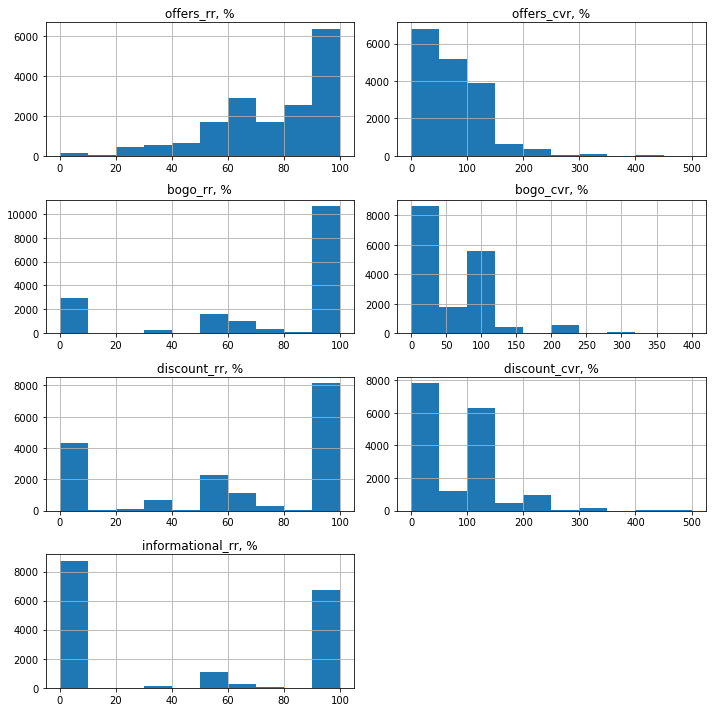

In [131]:
# if cvr > 100, it means more offers completed than offers viewed - waste of money
cols = ['offers_rr', 'offers_cvr','bogo_rr', 'bogo_cvr', 'discount_rr', 'discount_cvr','informational_rr']
plt.figure(figsize=(10, 10));

for i, each in enumerate(starbucks_imputed[cols]):
    plt.subplot(4,2,i+1)
    starbucks_imputed[each].hist();
    plt.title(f"{each}, %");
    plt.tight_layout();

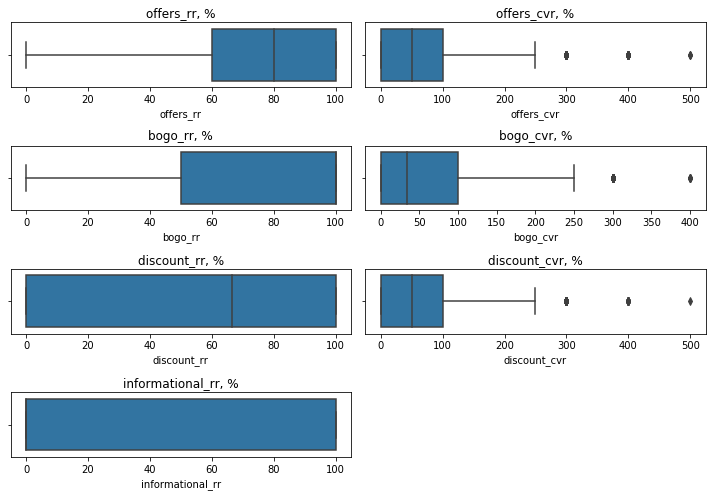

In [132]:
# if cvr > 100, it means more offers completed than offers viewed - waste of money
cols = ['offers_rr', 'offers_cvr','bogo_rr', 'bogo_cvr', 'discount_rr', 'discount_cvr','informational_rr']
plt.figure(figsize=(10, 7));

for i, each in enumerate(starbucks_imputed[cols]):
    plt.subplot(4,2,i+1)
    sns.boxplot(starbucks_imputed[each]);
    plt.title(f"{each}, %");
    plt.tight_layout();

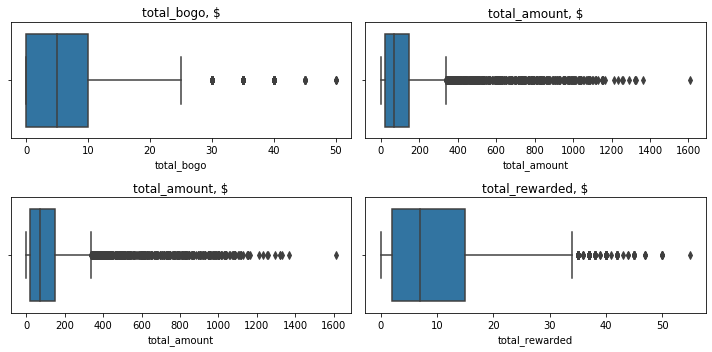

In [133]:
plt.figure(figsize=(10, 5));

for i, each in enumerate(starbucks_imputed[['total_bogo', 'total_amount', 'total_amount', 'total_rewarded']]):
    plt.subplot(2,2,i+1)
    sns.boxplot(starbucks_imputed[each]);
    plt.title(f"{each}, $");
    plt.tight_layout();

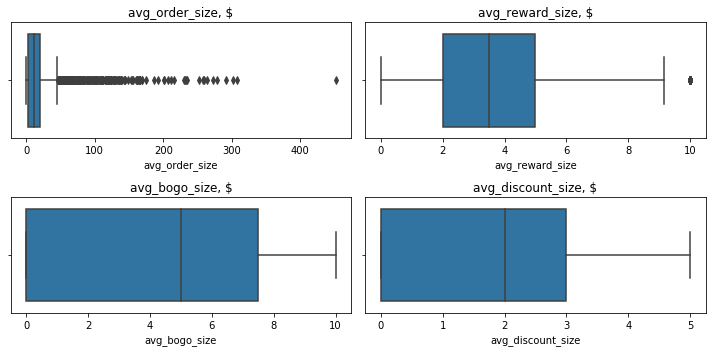

In [134]:
plt.figure(figsize=(10, 5));

for i, each in enumerate(starbucks_imputed[['avg_order_size', 'avg_reward_size','avg_bogo_size', 'avg_discount_size']]):
    plt.subplot(2,2,i+1)
    sns.boxplot(starbucks_imputed[each]);
    plt.title(f"{each}, $");
    plt.tight_layout();

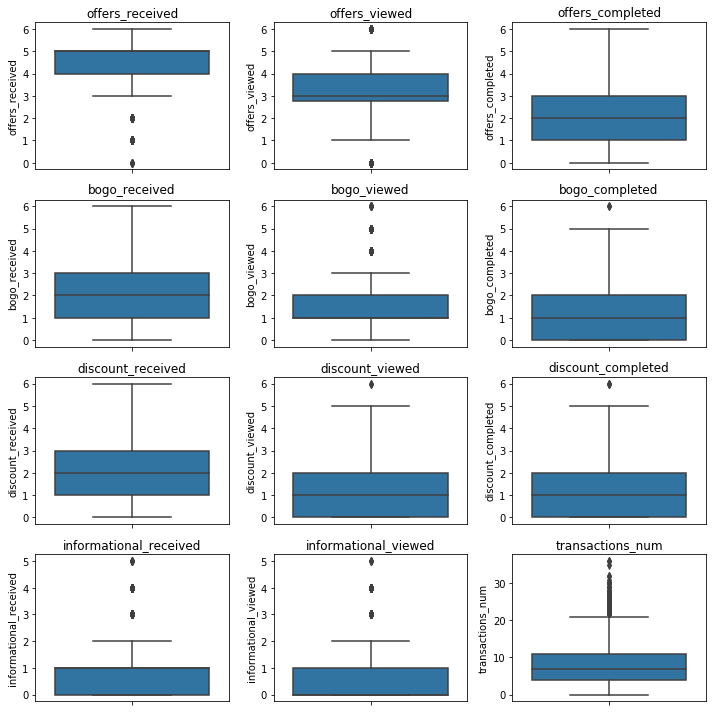

In [135]:
cols = ['offers_received','offers_viewed', 'offers_completed', 
        'bogo_received', 'bogo_viewed','bogo_completed', 
        'discount_received', 'discount_viewed','discount_completed', 
        'informational_received', 'informational_viewed', 'transactions_num']
    
plt.figure(figsize=(10, 10));

for i, each in enumerate(starbucks_imputed[cols]):
    plt.subplot(4,3,i+1)
    sns.boxplot(y=starbucks_imputed[each]);
    plt.title(f"{each}");
    plt.tight_layout();

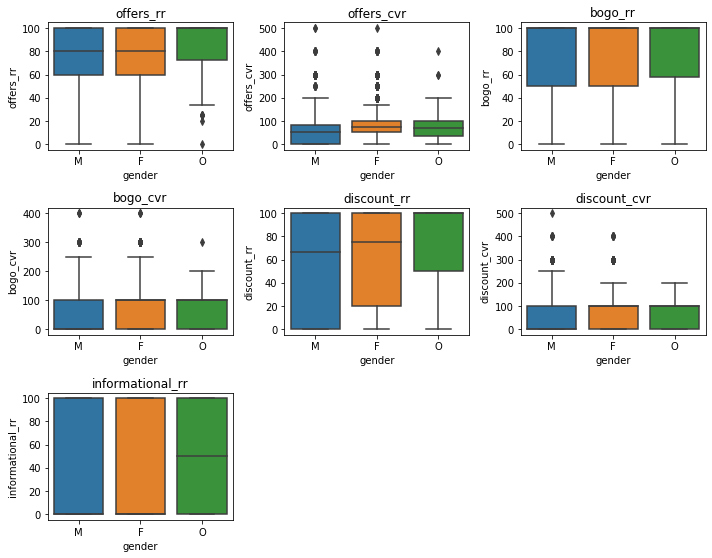

In [136]:
cols = ['offers_rr', 'offers_cvr','bogo_rr', 'bogo_cvr','discount_rr', 'discount_cvr','informational_rr']


plt.figure(figsize=(10, 10));

for i, each in enumerate(starbucks_imputed[cols]):
    plt.subplot(4,3,i+1)
    sns.boxplot(y=each, x='gender', data=starbucks_imputed);
    plt.title(f"{each}");
    plt.tight_layout();

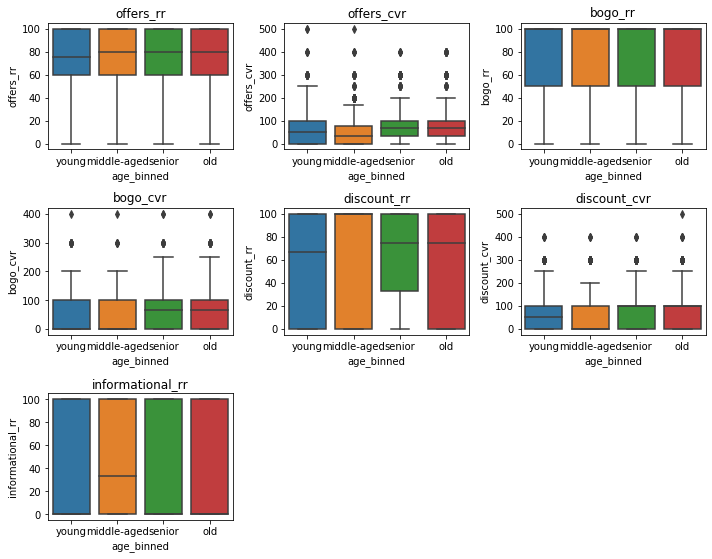

In [137]:
cols = ['offers_rr', 'offers_cvr','bogo_rr', 'bogo_cvr','discount_rr', 'discount_cvr','informational_rr']


plt.figure(figsize=(10, 10));

for i, each in enumerate(starbucks_imputed[cols]):
    plt.subplot(4,3,i+1)
    sns.boxplot(y=each, x='age_binned', data=starbucks_imputed);
    plt.title(f"{each}");
    plt.tight_layout();

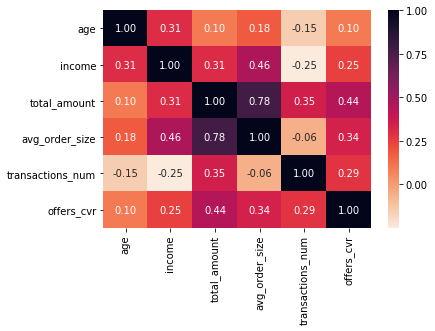

In [138]:
cols = ['became_member_on', 'age', 'income', 'total_amount', 'avg_order_size', 'transactions_num', 'offers_cvr']
sns.heatmap(starbucks_imputed[cols].corr(), cmap = 'rocket_r', annot = True, fmt = '.2f');

## Metrics

Promotional Effectiveness Metrics & Email Capture Benchmarks Across 10 Ecommerce Industries [2019 Report], https://www.bigcommerce.com/blog/promotional-marketing/#what-is-promotional-marketing

https://www.themailshark.com/resources/guides/how-to-track-measure-direct-mail/

https://nscpolteksby.ac.id/ebook/files/Ebook/Business%20Administration/Marketing%20Metrics%20(2006)/10.%20Chapter%208%20-%20PROMOTION.pdf


In [147]:
print(f"{(starbucks_imputed.offers_received != 0).sum()} customers received offers, while {(starbucks_imputed.offers_received == 0).sum()} did not")

16994 customers received offers, while 6 did not


In [148]:
print(f"Out of those who received, {((starbucks_imputed.offers_received != 0) & (starbucks_imputed.offers_viewed != 0)).sum()} customers viewed offers, while {((starbucks_aggr.offers_received != 0) & (starbucks_aggr.offers_viewed == 0)).sum()} did not")

Out of those who received, 16834 customers viewed offers, while 160 did not


In [149]:
print(f"Out of those who received & viewed, {((starbucks_imputed.offers_received != 0) & (starbucks_imputed.offers_viewed != 0) & (starbucks_aggr.offers_completed != 0)).sum()} customers completed the offers, while {((starbucks_aggr.offers_received != 0) & (starbucks_aggr.offers_viewed != 0) & (starbucks_aggr.offers_completed == 0)).sum()} did not")

Out of those who received & viewed, 12701 customers completed the offers, while 4133 did not


 ### Viewing Rate

In [151]:
# total viewing rate - % customers who viewed the offers
viewing_rate = (starbucks_imputed.offers_viewed > 0).sum()
round(viewing_rate/starbucks_imputed.shape[0]*100, 2)

99.02

### Rewarded Rate

In [152]:
# total rewarded rate - % customers who completed the offers 
rewarded_rate = (starbucks_imputed.offers_completed > 0).sum()
print(f"rewarded rate is {rewarded_rate/starbucks_imputed.shape[0]*100:.2f}%. Right now this number also includes customers that did not interact with the offers but got rewarded.")

rewarded rate is 75.14%. Right now this number also includes customers that did not interact with the offers but got rewarded.


Let's find misattributed customers who should not have been rewarded (those that did not interact with offers but completed offers) and calculate the waisted sum. I do it in two steps:
- first, I find those that did not interact with any of the offers and still got rewarded; 
- second, I find those that got more offers completed than they actually viewed.

**not engaged Conversion rate (CVR)** - % who DID NOT interact with the offers and still got rewarded.

In [145]:
no_views_cvr = starbucks_imputed[(starbucks_imputed.offers_viewed == 0) & (starbucks_imputed.offers_completed > 0)]
cvr_noviews_num = no_views_cvr.shape[0]
cvr_noviews_bogo_total = (no_views_cvr.bogo_received * no_views_cvr.avg_bogo_size).sum()
cvg_noviews_discount_total = (no_views_cvr.discount_received * no_views_cvr.avg_discount_size).sum()
cvr_noviews_total = cvr_noviews_bogo_total + cvg_noviews_discount_total

print(f"there are {round(cvr_noviews_num/starbucks_aggr.shape[0]*100, 2)}% of customers who did not interact with the offers, but still got rewarded in total of ${cvr_noviews_total}")
print(f"Starbucks could have saved ${cvr_noviews_bogo_total} on bogos and ${cvg_noviews_discount_total} on discounts")

there are 0.43% of customers who did not interact with the offers, but still got rewarded in total of $718.0
Starbucks could have saved $362.5 on bogos and $355.5 on discounts


**bad CVR** - more offers completed than viewed

In [ ]:
morethanviewed_cvr = starbucks_imputed[starbucks_imputed.offers_cvr > 100]
cvr_morethanviewed_num = morethanviewed_cvr.shape[0]

#calculating the overpaid amount - num incorrectly attributed offers (bogo or discount) * average offer size
bogo_overpaid = (morethanviewed_cvr.bogo_received - morethanviewed_cvr.bogo_viewed)*morethanviewed_cvr.avg_bogo_size
bogo_overpaid_total = bogo_overpaid.sum()
discount_overpaid = (morethanviewed_cvr.discount_received - morethanviewed_cvr.discount_viewed)*morethanviewed_cvr.avg_discount_size
discount_overpaid_total = discount_overpaid.sum()
morethanviewed_cvr_amount = bogo_overpaid_total + discount_overpaid_total

print(f"there are {round(cvr_morethanviewed_num/starbucks_aggr.shape[0]*100, 2)}% who got more offers completed than actually viewed")
print(f"This means that these customers made transactions regardless of offers they received and thus Starbucks overpaid about ${morethanviewed_cvr_amount} or {morethanviewed_cvr_amount/starbucks_aggr.total_rewarded.sum()*100:.2f}% of its total marketing cost")
print(f"More specifically, Starbucks could have saved on bogos: ${bogo_overpaid_total} and on discounts: ${discount_overpaid_total: .2f}")

**Note:** About 12% of all customers completed offers even though they did not interact with them. As a result, about \\$16233 or almost 10% of the marketing cost got waisted.

Only correctly secured campaigns should be a source of relevant data. 

In [ ]:
# TODO: maybe replace those with cvr>100 with cvr=100 
# --> replace bogo_completed with bogo_viewed + discount_completed with discount_viewed

**Engaged conversion rate (CVR)** - number of those who interacted with the offers and got rewarded.

In [153]:
engaged_cvr = ((starbucks_imputed.offers_received != 0) & (starbucks_imputed.offers_viewed > 0) & (starbucks_imputed.offers_completed > 0)).sum()
print(f"there are {round(engaged_cvr/starbucks_imputed.shape[0]*100, 2)}% of customers received and viewed the offers and got rewarded in total of ${starbucks_imputed[((starbucks_imputed.offers_received != 0) & (starbucks_imputed.offers_viewed > 0) & (starbucks_imputed.offers_completed > 0))].total_rewarded.sum()}")

there are 74.71% of customers received and viewed the offers and got rewarded in total of $164137.0


## Predict engaged CVR

In [154]:
starbucks_engaged = starbucks_imputed.copy().iloc[:, 1:11]

In [155]:
starbucks_engaged.head()

,became_member_on,gender,age,income,total_amount,total_rewarded,transactions_num,offers_received,offers_viewed,offers_completed
0,2017,M,55.0,64000.0,20.40,5.0,9,5,5,2
1,2017,F,55.0,112000.0,77.01,5.0,3,2,0,1
2,2018,M,55.0,64000.0,14.30,0.0,6,2,2,0
3,2017,F,75.0,100000.0,159.27,20.0,7,4,4,3
4,2017,M,55.0,64000.0,4.65,0.0,3,5,3,0


In [157]:
# create a column 'conversion' => 1 if received & viewed & completed, 0 if not
starbucks_engaged['conversion'] = ((starbucks_imputed.offers_received != 0) & (starbucks_imputed.offers_viewed > 0) & (starbucks_imputed.offers_completed > 0))
starbucks_engaged['conversion'] = starbucks_engaged['conversion'].apply(lambda x: 1 if x == True else 0)

In [158]:
starbucks_engaged.head()

,became_member_on,gender,age,income,total_amount,total_rewarded,transactions_num,offers_received,offers_viewed,offers_completed,conversion
0,2017,M,55.0,64000.0,20.40,5.0,9,5,5,2,1
1,2017,F,55.0,112000.0,77.01,5.0,3,2,0,1,0
2,2018,M,55.0,64000.0,14.30,0.0,6,2,2,0,0
3,2017,F,75.0,100000.0,159.27,20.0,7,4,4,3,1
4,2017,M,55.0,64000.0,4.65,0.0,3,5,3,0,0


Revenue 

In [159]:
revenue = starbucks_imputed.total_amount.sum()
revenue

1775451.9699999997

Campaign cost

In [160]:
campaign_cost = starbucks_imputed.total_rewarded.sum()
campaign_cost

164676.0

Cost per Acquisition (CPA) -  "also known as cost per order or lead – tells you how much each new customer cost to obtain."

In [161]:
# campaign cost per transaction
cost_per_acquisition = campaign_cost/starbucks_imputed.transactions_num.sum()
cost_per_acquisition

1.1851201485394343

Average Order Size 

In [162]:
# revenue per transaction
average_order_size = revenue/starbucks_imputed.transactions_num.sum()
average_order_size

12.777356156398204

Revenue per Order - how much profit you made from each order on average

In [163]:
revenue_per_order = average_order_size-cost_per_acquisition
revenue_per_order

11.59223600785877

Return on Investment (ROI), %

In [164]:
roi = (revenue-campaign_cost)/campaign_cost * 100
roi

978.1485887439576

# Data Preprocessing

### One-Hot Encoding categorical data

In [212]:
# drop person id from further analysis
starbucks_ohe = starbucks_binned.copy()

starbucks_ohe.drop('person', axis=1, inplace=True)

In [213]:
categorical_col = starbucks_ohe.columns[(starbucks_ohe.dtypes == 'category') | (starbucks_ohe.dtypes == 'object')]
categorical_col

Index(['became_member_on', 'gender', 'age_binned', 'income_binned',
       'total_amount_binned', 'total_rewarded_binned',
       'transactions_num_binned', 'avg_order_size_binned',
       'avg_reward_size_binned', 'total_bogo_binned', 'total_discount_binned',
       'avg_bogo_size_binned', 'avg_discount_size_binned'],
      dtype='object')

In [214]:
# TODO: try OneHotEncoder 
starbucks_ohe = pd.get_dummies(starbucks_ohe, columns=categorical_col)

In [215]:
starbucks_ohe.head()

,offers_rr,offers_cvr,bogo_rr,bogo_cvr,discount_rr,discount_cvr,informational_rr,became_member_on_2013,became_member_on_2014,became_member_on_2015,...,total_discount_binned_total_discount_medium,total_discount_binned_total_discount_large,avg_bogo_size_binned_no_avg_bogo_size,avg_bogo_size_binned_avg_bogo_size_small,avg_bogo_size_binned_avg_bogo_size_medium,avg_bogo_size_binned_avg_bogo_size_large,avg_discount_size_binned_no_avg_discount_size,avg_discount_size_binned_avg_discount_size_small,avg_discount_size_binned_avg_discount_size_medium,avg_discount_size_binned_avg_discount_size_large
0,100.0,40.0,0.0,0.0,100.00,40.0,0.0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2,100.0,0.0,100.0,0.0,0.00,0.0,100.0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,100.0,75.0,100.0,100.0,0.00,0.0,100.0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
4,60.0,0.0,0.0,0.0,66.67,0.0,50.0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [216]:
starbucks_ohe.shape

(17000, 60)

### Feature Scaling

In [217]:
scaler = StandardScaler().fit(starbucks_ohe) 
starbucks_scaled = scaler.transform(starbucks_ohe)

In [218]:
#checking scaling results on first 5 features
starbucks_scaled.std(axis=0)[:5], starbucks_scaled.mean(axis=0)[:5]

(array([1., 1., 1., 1., 1.]),
 array([-2.39494699e-16,  1.14940737e-18, -8.15034315e-17,  2.95711168e-17,
        -1.95399252e-16]))

Note: scaler works as expected - all features were transformed correctly and have mean around 0 and std 1.

In [ ]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler().fit(starbucks_ohe) 
# starbucks_scaled = scaler.transform(starbucks_ohe)

# Implementation

## Dimensionality Reduction via PCA

In [219]:
# Apply PCA to the data.
pca = PCA()
X_pca = pca.fit_transform(starbucks_scaled)

In [220]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

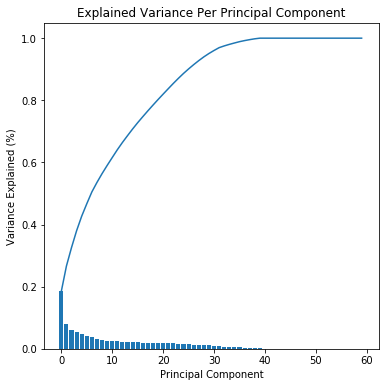

In [221]:
scree_plot(pca)

In [222]:
# how many components together explain about 80% of variance?
cum_expl_var_ratio = np.cumsum(pca.explained_variance_ratio_)
components_num = len(cum_expl_var_ratio[cum_expl_var_ratio <= 0.805])
components_num

20

In [223]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(components_num).fit(starbucks_scaled)
starbucks_pca = pca.transform(starbucks_scaled)

In [224]:
starbucks_pca.shape

(17000, 20)

In [225]:
np.cumsum(pca.explained_variance_ratio_)

array([0.18522868, 0.26629511, 0.32581504, 0.38012901, 0.4268903 ,
       0.46686595, 0.5050454 , 0.53555731, 0.5638362 , 0.59019807,
       0.61561313, 0.64074518, 0.66413789, 0.68607342, 0.70751591,
       0.72788616, 0.74712028, 0.76588492, 0.78421366, 0.80219579])

**Note:** As a rule of thumb, one should keep as many components that together they would explain about 80% of variance. From the scree plot we can conclude that about 19 components explain 80% of variance. So I decided to keep 19 PCA components for the clustering part of the project. <br>

# Clustering

In [295]:
import time

# Over a number of different cluster counts...
range_n_clusters = [2, 3, 5, 8, 10, 15]
sum_of_squared_distances = []
since = time.time()

for n_clusters in range_n_clusters:
    cluster_start = time.time()
    print("calculating {} clusters".format(n_clusters))
    # run k-means clustering on the data and...
    clusterer = KMeans(n_clusters=n_clusters, random_state=120).fit(starbucks_pca)

    # ... compute the average within-cluster distances.
    sum_of_squared_distances.append(clusterer.inertia_)
    print("sum of squared distances:", clusterer.inertia_)
    print("time for this cluster:", time.time() - cluster_start)

time_elapsed = time.time() - since
print('Clustering complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

calculating 2 clusters
sum of squared distances: 647323.429435142
time for this cluster: 0.2741560935974121
calculating 3 clusters
sum of squared distances: 577112.039065456
time for this cluster: 0.1974959373474121
calculating 5 clusters
sum of squared distances: 477366.84559274383
time for this cluster: 0.39327192306518555
calculating 8 clusters
sum of squared distances: 421972.8657830902
time for this cluster: 0.4871790409088135
calculating 10 clusters
sum of squared distances: 399068.27460045076
time for this cluster: 0.7303011417388916
calculating 15 clusters
sum of squared distances: 357027.4511874453
time for this cluster: 1.0177531242370605
Clustering complete in 0m 3s


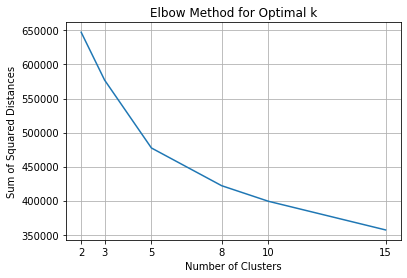

In [296]:
plt.plot(range_n_clusters, sum_of_squared_distances)
plt.xlabel('Number of Clusters')
plt.xticks(range_n_clusters, range_n_clusters)
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal k')
plt.grid();

In [306]:
# Re-fit the k-means model with the selected number of clusters and obtain cluster predictions
clusterer = KMeans(n_clusters=5, random_state = 123).fit(starbucks_pca)
starbucks_preds = clusterer.predict(starbucks_pca)

# Model Evaluation

In [307]:
def interpret_cluster(cluster_num, df):
    pca_inversed = pca.inverse_transform(clusterer.cluster_centers_[cluster_num, :])
    scaler_inversed = np.around(scaler.inverse_transform(pca_inversed), decimals=2)
    results_df = pd.DataFrame(scaler_inversed, df.columns)
    return results_df

In [308]:
def create_cluster_df(cluster_num, df):
    cluster_df = pd.DataFrame(interpret_cluster(0, df))
    cluster_df.drop(0, axis=1, inplace=True)

    for i in range(cluster_num):
        cluster_df['cluster_'+str(i+1)] = interpret_cluster(i, df)
    return cluster_df

In [309]:
cluster_df = create_cluster_df(5, starbucks_ohe) 
means = []
for each in starbucks_ohe.columns:
    mean = round(starbucks_ohe[each].mean(), 2)
    means.append(mean)
means_df = pd.DataFrame(means, index=cluster_df.index, columns=['means'])
cluster_df_fin = cluster_df.merge(means_df, on=cluster_df.index)
cluster_df_fin.index = cluster_df_fin.key_0
cluster_df_fin.drop('key_0', axis=1, inplace=True)
cluster_df_fin

,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,means
key_0,,,,,,
offers_rr,82.22,75.08,78.45,71.91,72.36,76.01
offers_cvr,96.93,81.27,-0.06,-1.43,60.07,61.01
bogo_rr,90.77,81.07,74.22,69.66,45.47,73.87
bogo_cvr,105.39,79.57,-0.73,-2.61,0.23,50.45
discount_rr,63.85,59.75,68.11,47.43,76.98,61.97
discount_cvr,78.51,71.00,-1.78,-4.13,102.11,61.03
informational_rr,40.59,43.59,36.86,43.59,51.37,44.14
became_member_on_2013,0.01,0.02,0.01,0.00,0.03,0.02
became_member_on_2014,0.03,0.04,0.00,0.04,0.07,0.04


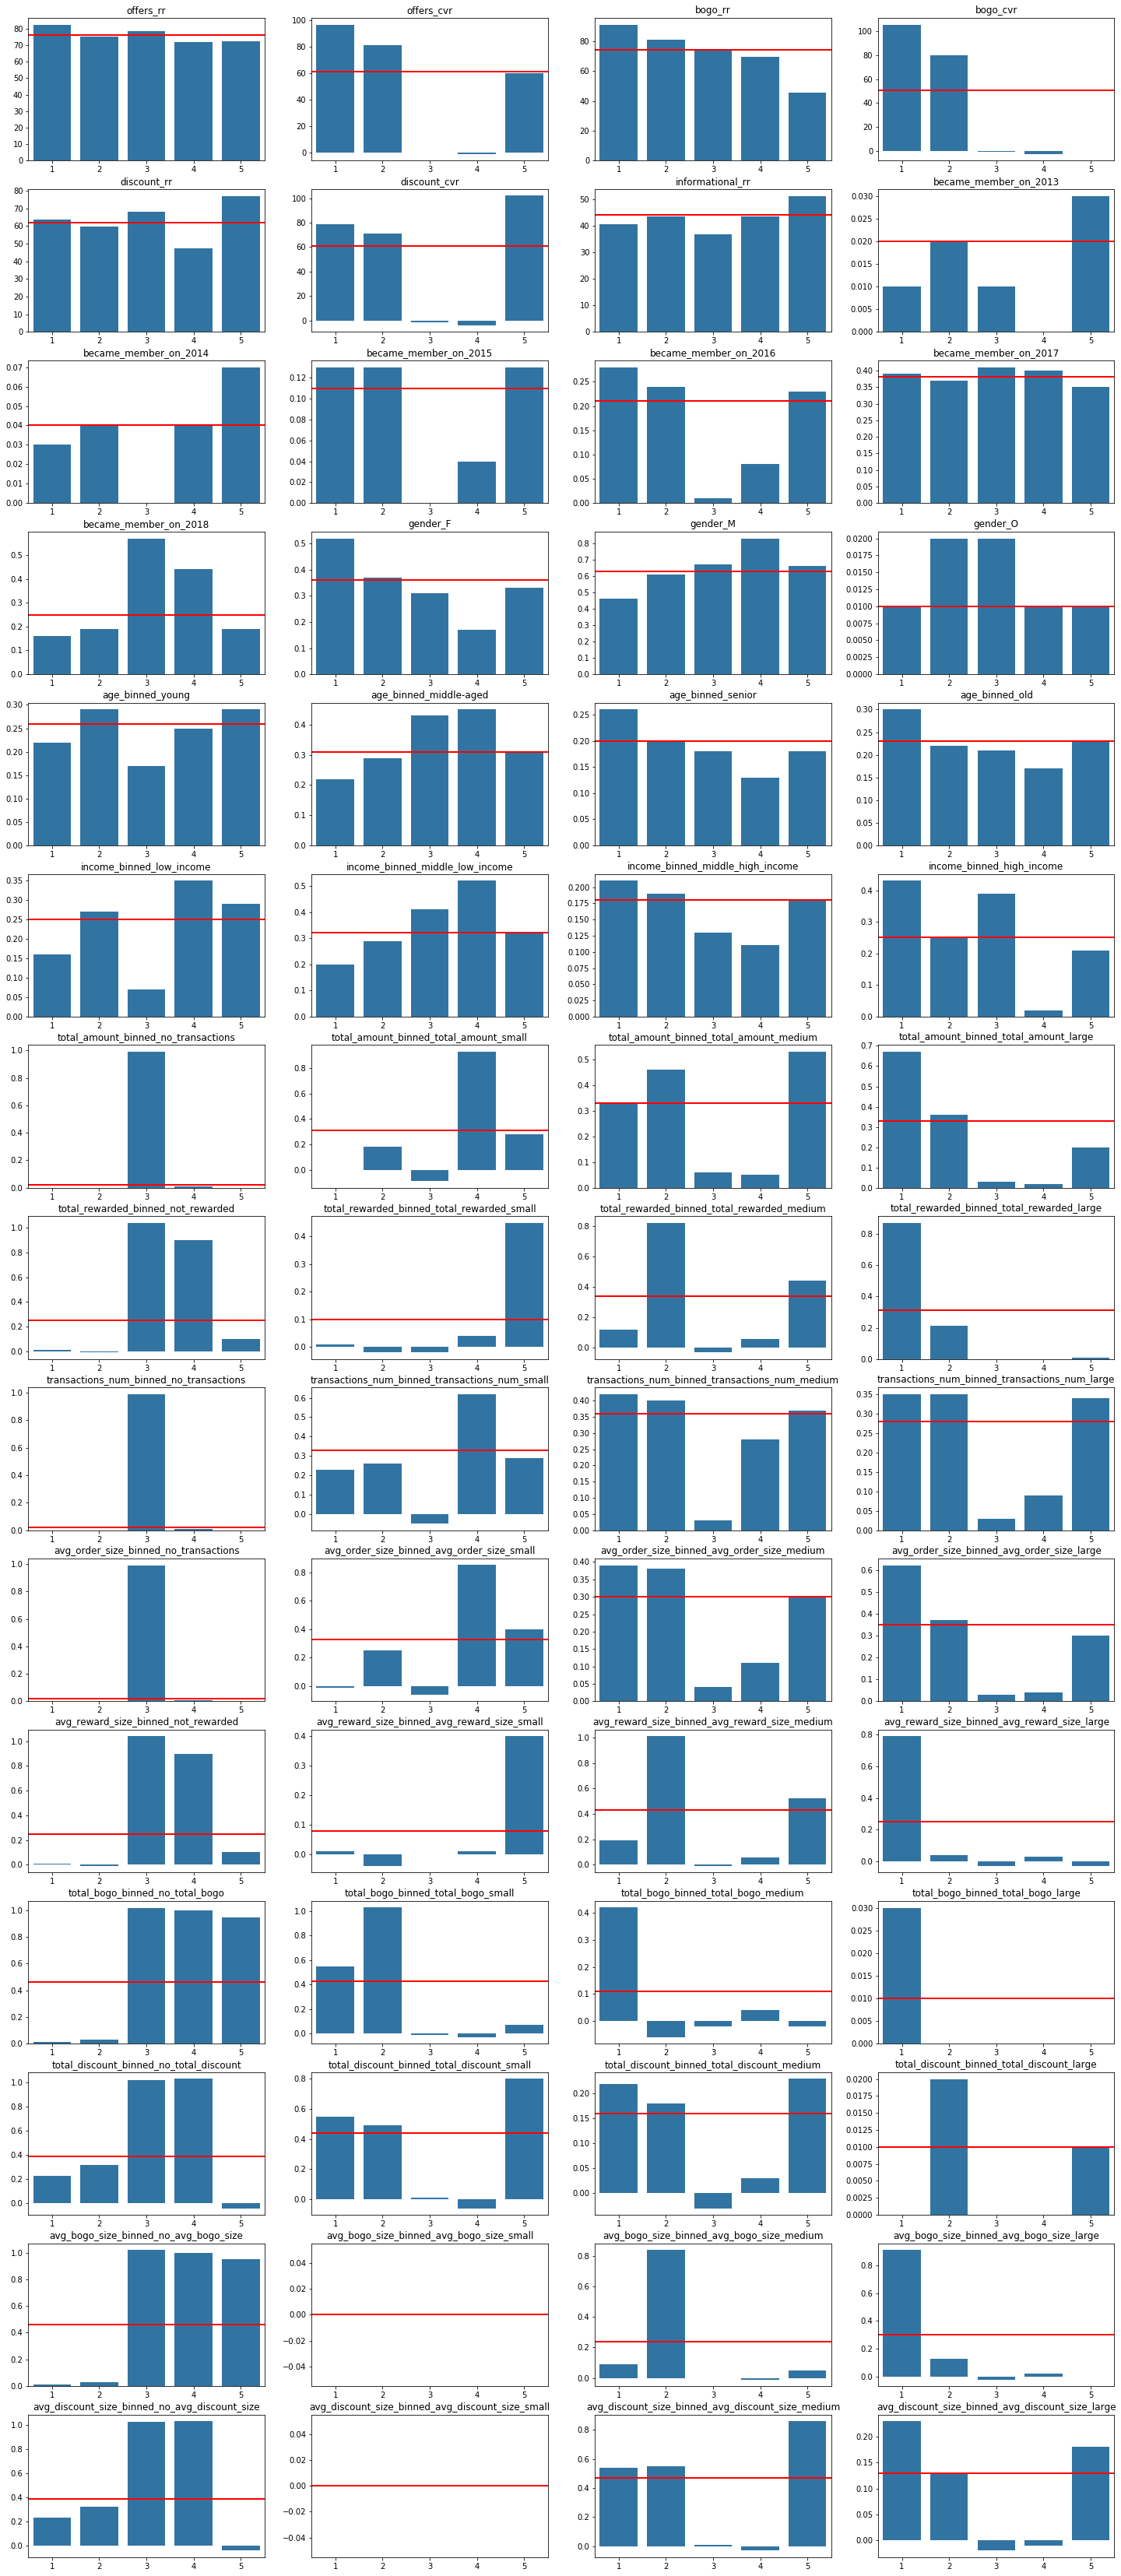

In [310]:
number_subplot = len(cluster_df_fin.T.columns)
base_color = sns.color_palette()[0]
plt.figure(figsize=(25, 60));

for i, each in enumerate(cluster_df_fin.T.columns):
    ax = plt.subplot(number_subplot/4,4,i+1)
    sns.barplot(y=each, x=['1', '2', '3', '4', '5'], data=cluster_df_fin.T.iloc[:-1, :], color=base_color);
    plt.title(f"{each}");
    ax.axhline(y=cluster_df_fin.T[each][-1], linewidth=2, color='r');
    plt.ylabel("");


## Clusters:

### Cluster  - "most engaged": 
* female + old/senior + middle-high/high income + 2015/2016 member
* large total_amount, medium/large transactions_num + medium/large avg_order_size
* large total_rewarded, large avg_reward_size + small/medium/large bogo + small/medium discounts
* large avg_bogo_size, large avg_discount_size
* the highest offers_cvr, bogo_cvr, discount_cvr

**Senior women with high income that have been customers for a few years (members since 2015/2016) tend to spend a lot and often. Hence this group gets the highest rewards on both bogo and discounts, but is mostly after large bogos. These are also the most engaged customers as they have the highest conversion rates.**

### Cluster - "core customers":
* female/male/other + young/old + 2013/2014/2015 member + low/middle-high income
* medium total_amount + medium/large transactions_num + medium avg_order_size
* medium total_reward + medium avg_reward_size + small total_bogo + small/medium/large(!) total_discount
* high offers_cvr + high discount_cvr + high bogo_cvr 
* medium avg_bogo_size, medium avg_discount_size 
* the highest informational_rr

**The core customers don't have a clear-cut profile as they come almost equally from all gender, age and income groups. These are established customers, as they have been members for a few years already (members since 2013-2015). They spend medium amount of money quite often and hence get medium-size rewards, mostly in form of medium discounts and small bogo. They have high conversion rates both on discounts and bogo and have the highest informational response rate.**

### Cluster - "discount-type":
* young/middle aged + men + 2013-2016 members + low/middle-low income 
* medium total_amount + medium/large transactions_num + small avg_order_size
* small total_rewarded + small/medium avg_reward_size
* no_total_bogo 
* small/medium total_discount + medium/large avg_discount_size
* high discount_cvr
* high discount_rr

**Young men with low income that are long-time customers (members since 2013/2014) normally make small/medium purchases, but do so frequently. This group is apparently not interested in bogos, but reacts well to discounts. The rewarded amount is usually small or medium.**


### Cluster - "disinterested": 
* middle-aged + men + low/middle-low income + 2017/2018 member
* small total_amount, small transactions_num + small avg_order_size
* not_rewarded, no total_bogo, no total_discount
* almost zero offers_cvr, bogo_cvr and discount_cvr
* offers_rr, bogo_rr and informational_rr about average

**Middle-aged men with low/middle-low income that are recent members (since 2018) spend very little amount infrequently and hence not get rewarded. This group is not interested in offers of any kind.**


### Cluster - "not a customer (yet)":
* middle/aged + men/other + 2018 member + middle-low/high income
* no_transactions --> not_rewarded
* average offers_rr and bogo_rr, slightly above average discount_rr

**Middle-aged men (or 'other' gender) with either middle-low or high income that just became members recently (2017/2018) didn't make any transactions during the experiment. As a result, they didn't get rewarded. However, this group views offers (first of all bogo) on average and has slightly above average discount reponse rate, which means that they might become customers in the future.**



# Validation

In [324]:
starbucks_predicted = starbucks_imputed.copy()
starbucks_predicted['segments'] = starbucks_preds

In [325]:
# assign specific labels based on key characteristics automatically:
labels = []
for i in range(len(starbucks_predicted['segments'].unique())):
    subset = starbucks_predicted[starbucks_predicted['segments'] == i]
    if (subset.gender == 'F').sum() > (subset.gender == 'M').sum():
        print(i+1, "most engaged")
        labels.append(str(i+1)+"_most engaged")
    elif (subset.transactions_num_binned == 'no_transactions').sum() > (subset.transactions_num_binned == 'transactions_num_small').sum():
        print(i+1, "not a customer (yet)")
        labels.append(str(i+1)+"_not a customer (yet)")
    elif subset.discount_cvr.mean() > subset.offers_cvr.mean():
        print(i+1, "discount-type")
        labels.append(str(i+1)+"_discount-type")
    elif (subset.avg_order_size_binned == 'avg_order_size_small').sum() > (subset.avg_order_size_binned == 'avg_order_size_medium').sum():
        print(i+1, "disinterested")
        labels.append(str(i+1)+"_disinterested")
    else:
        print(i+1, "core customers")
        labels.append(str(i+1)+"_core customers")

1 most engaged
2 core customers
3 not a customer (yet)
4 disinterested
5 discount-type


In [326]:
# encode the segments with labels
# note: LabelEncoder sorts labels in alphabetic order, which is bad for us. 
# Because we have clusters in particular order and want to do inverse_transform, we need to start labels with numbers
le = LabelEncoder()
le.fit(labels)
starbucks_predicted['segments_labeled'] = le.inverse_transform(starbucks_preds)

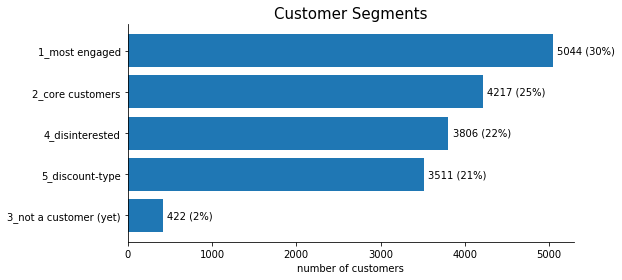

In [327]:
fig = plt.figure(figsize=(8, 4));

yticks = starbucks_predicted['segments_labeled'].value_counts(ascending=True)
plt.barh(range(5), yticks, tick_label=yticks.index);
plt.title("Customer Segments", fontsize=15);
plt.xlabel("number of customers")
for i, v in enumerate(yticks):
    count = str(v)+" ("+str(round(v/starbucks_predicted.shape[0]*100))+"%)"
    plt.text(v+50, i, count, va='center');
sns.despine(fig);


## Metrics

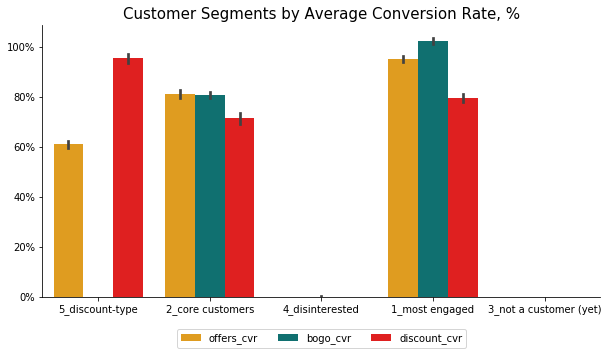

In [328]:
cols = ['offers_cvr', 'bogo_cvr', 'discount_cvr']
fig, ax = plt.subplots(figsize=(10, 5))

tidy = starbucks_predicted.melt(id_vars='segments_labeled', value_vars=cols).rename(columns=str.title)
barplot = sns.barplot(x='Segments_Labeled', y='Value', hue='Variable', data=tidy, ax=ax, palette=['orange', 'teal', 'red']);
plt.xlabel("");
plt.ylabel("");
plt.title("Customer Segments by Average Conversion Rate, %", fontsize=15);
sns.despine(fig);
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0f}%'.format(y)))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3);

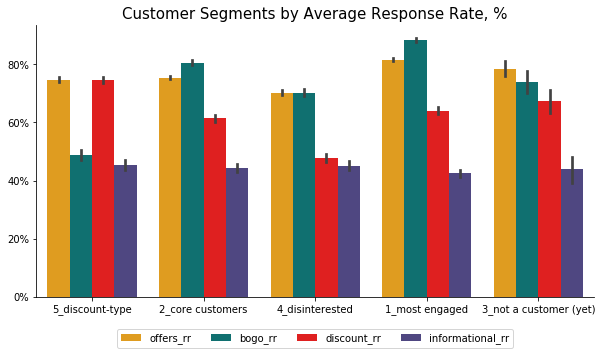

In [329]:
cols = ['offers_rr', 'bogo_rr', 'discount_rr', 'informational_rr']
fig, ax = plt.subplots(figsize=(10, 5))

tidy = starbucks_predicted.melt(id_vars='segments_labeled', value_vars=cols).rename(columns=str.title)
barplot = sns.barplot(x='Segments_Labeled', y='Value', hue='Variable', data=tidy, ax=ax, palette=['orange', 'teal', 'red', 'darkslateblue']);
plt.xlabel("");
plt.ylabel("");
plt.title("Customer Segments by Average Response Rate, %", fontsize=15);
sns.despine(fig);
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0f}%'.format(y)))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4);

## Spending Habits

In [330]:
def boxplot_by_segments(col, title):
    '''
    Input: 
        col: column name as string
        title: plot's title as string
    Output: none
    '''
    fig = plt.figure(figsize=(8, 5));
    sns.boxplot(x=col, y='segments_labeled', data=starbucks_predicted);
    plt.title(title, fontsize=15);
    plt.xlabel("");
    plt.ylabel("");
    sns.despine(fig);
    plt.tight_layout();

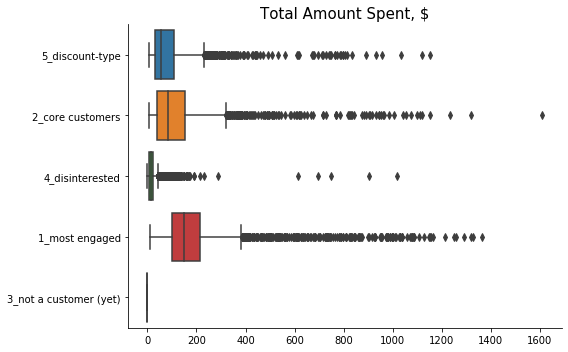

In [331]:
boxplot_by_segments('total_amount', "Total Amount Spent, $")

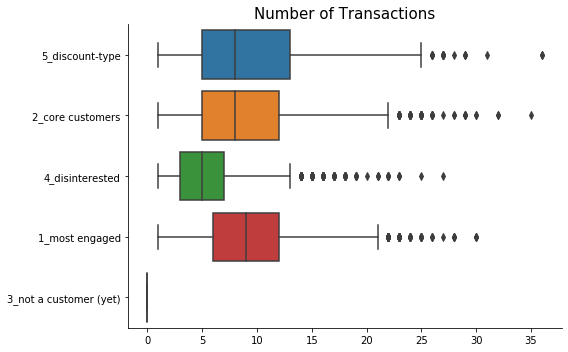

In [332]:
boxplot_by_segments('transactions_num', "Number of Transactions")

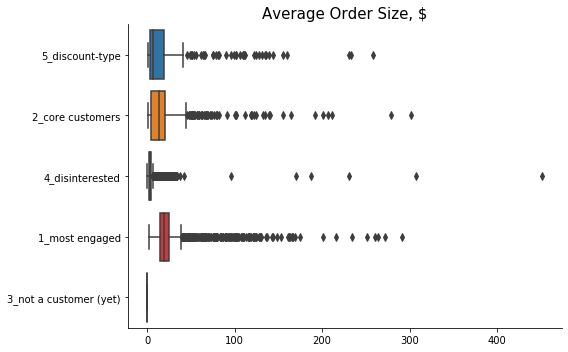

In [333]:
boxplot_by_segments('avg_order_size', "Average Order Size, $")

## Rewards Patterns

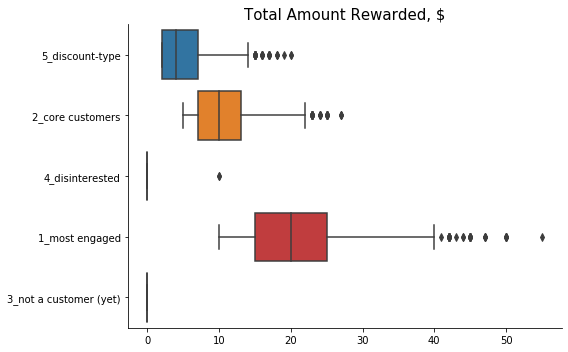

In [334]:
boxplot_by_segments('total_rewarded', "Total Amount Rewarded, $")

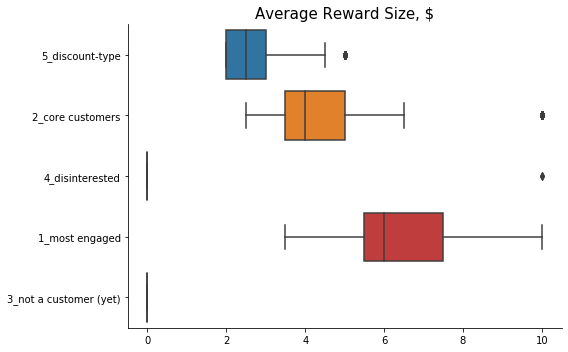

In [335]:
boxplot_by_segments('avg_reward_size', "Average Reward Size, $")

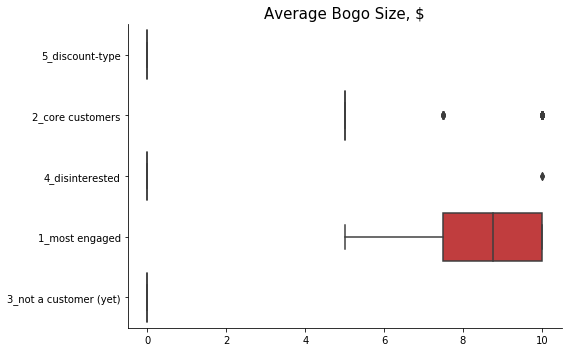

In [336]:
boxplot_by_segments('avg_bogo_size', "Average Bogo Size, $")

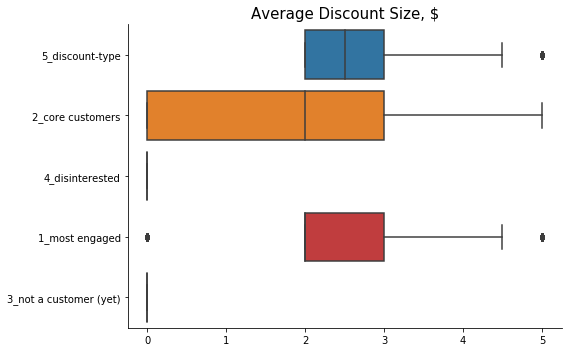

In [337]:
boxplot_by_segments('avg_discount_size', "Average Discount Size, $")

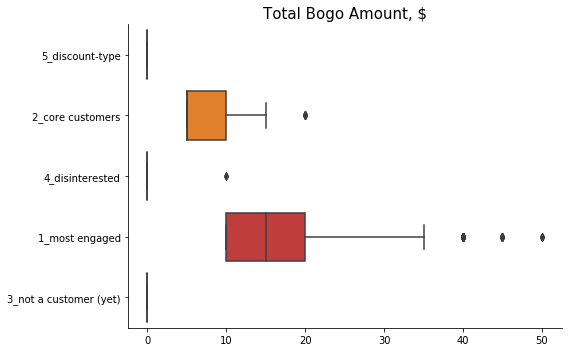

In [338]:
boxplot_by_segments('total_bogo', "Total Bogo Amount, $")

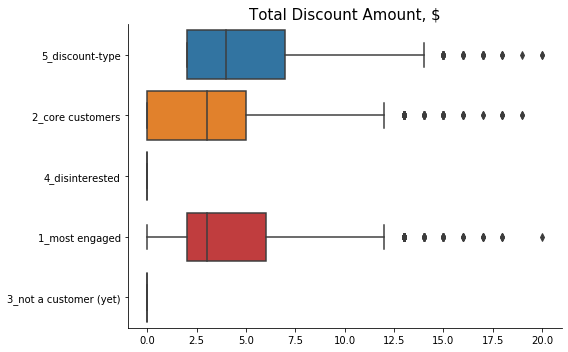

In [339]:
boxplot_by_segments('total_discount', "Total Discount Amount, $")

# Profile

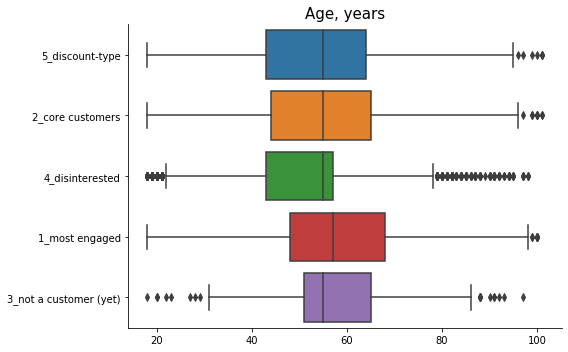

In [340]:
fig = plt.figure(figsize=(8, 5));
sns.boxplot(x='age', y='segments_labeled', data=starbucks_predicted);
plt.title("Age, years", fontsize=15);
plt.xlabel("");
plt.ylabel("");
sns.despine(fig);
plt.tight_layout();

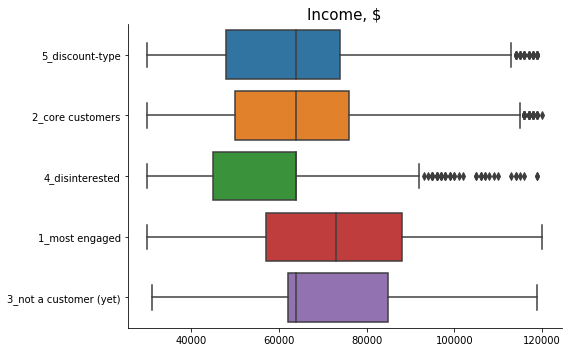

In [341]:
fig = plt.figure(figsize=(8, 5));
sns.boxplot(x='income', y='segments_labeled', data=starbucks_predicted);
plt.title("Income, $", fontsize=15);
plt.xlabel("");
plt.ylabel("");
sns.despine(fig);
plt.tight_layout();

In [342]:
# to plot became_member_on and gender features we need dummies 
# right now we don't have these columns in starbucks_predicted
# because we copied from starbucks_imputed
# add columns from starbucks_ohe
cols = ['became_member_on_2013','became_member_on_2014', 
        'became_member_on_2015','became_member_on_2016', 
        'became_member_on_2017','became_member_on_2018', 
        'gender_F', 'gender_M', 'gender_O']

for each in cols:
    starbucks_predicted[each] = starbucks_ohe[each]

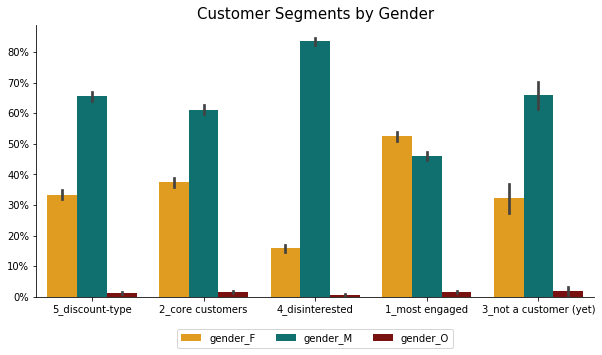

In [343]:
fig, ax = plt.subplots(figsize=(10, 5))
tidy = starbucks_predicted.melt(id_vars='segments_labeled', value_vars=['gender_F', 'gender_M','gender_O']).rename(columns=str.title)
barplot = sns.barplot(x='Segments_Labeled', y='Value', hue='Variable', data=tidy, ax=ax, palette=['orange', 'teal', 'darkred']);
plt.xlabel("");
plt.ylabel("");
plt.title("Customer Segments by Gender", fontsize=15);
sns.despine(fig);
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3);

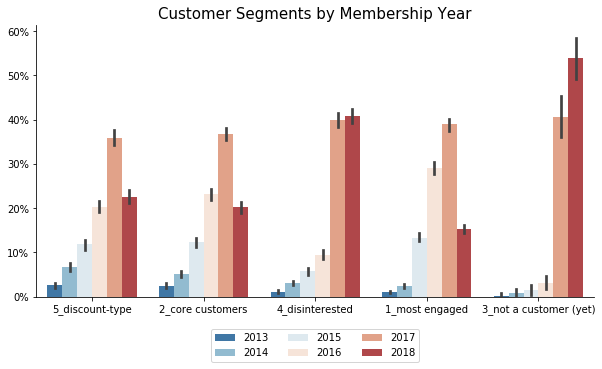

In [344]:
cols = ['became_member_on_2013','became_member_on_2014', 
        'became_member_on_2015','became_member_on_2016', 
        'became_member_on_2017','became_member_on_2018']
fig, ax = plt.subplots(figsize=(10, 5))

#change ugly labels 'became_member_on_2013' to '2013', etc
tidy = starbucks_predicted.melt(id_vars='segments_labeled', value_vars=cols).rename(columns=str.title)
for col, year in zip(cols, [str(x) for x in range(2013, 2019)]):
    tidy.Variable = [v.replace(col, year) for v in tidy.Variable.values]
    
barplot = sns.barplot(x='Segments_Labeled', y='Value', hue='Variable', data=tidy, ax=ax, palette='RdBu_r');
plt.xlabel("");
plt.ylabel("");
plt.title("Customer Segments by Membership Year", fontsize=15);
sns.despine(fig);
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
mylabels=['2013', '2014', '2015', '2016', '2017', '2018'] 
myhandles=sns.color_palette("RdBu_r", 6)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3);